<a href="https://colab.research.google.com/github/JurugoBrian/MoE_Models/blob/main/EfficientNetB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Installing and Importing Libraries

In [ ]:
pip install split-folders

In [ ]:
# Import necessary libraries
import os
import random
import shutil
import splitfolders
import pandas as pd
import seaborn as sns
from PIL import Image
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing import image_dataset_from_directory

# 2 Loading Datasets

In [ ]:
# Mount Google Drive and Load Datasets and define the paths to the datasets
drive.mount('/content/drive')
input_dir = '/content/drive/MyDrive/2025/MCSC_Research/cancer_dataset/input'     # Base directory containing the dataset
output_dir = '/content/drive/MyDrive/2025/MCSC_Research/cancer_dataset/output'  # Output directory where the split datasets will be stored
classes = ['Dyskeratotic', 'Koilocytotic', 'Metaplastic', 'Parabasal', 'Superficial-Intermediate']  # Define the classes

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3 Data Quality Assessment

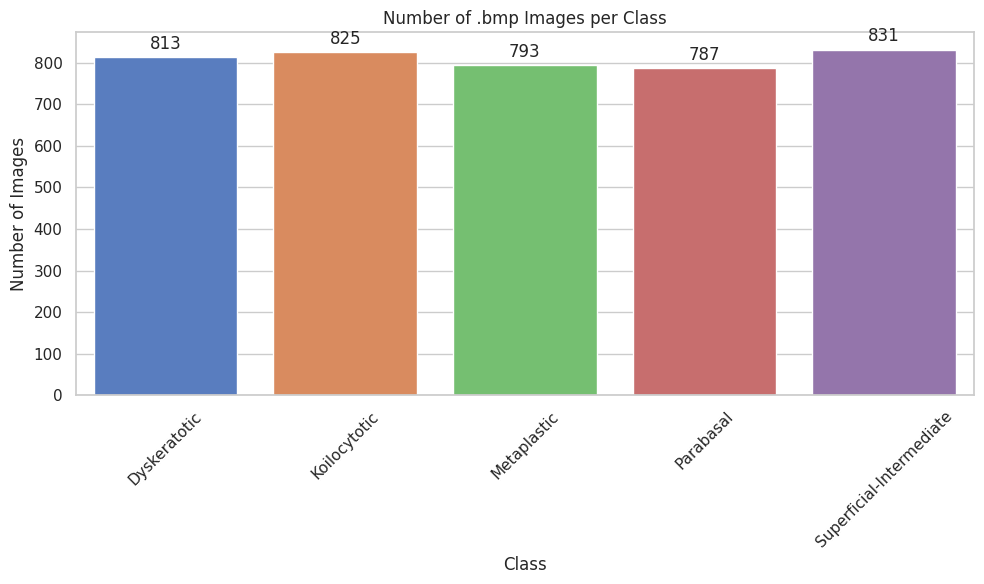

In [ ]:

# Initialize a dictionary to hold class names and their image counts
class_counts = {}

# Iterate over each class directory in the input directory
for class_name in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_name)
    if os.path.isdir(class_path):
        # Count the number of .bmp images in the class directory
        image_count = len([
            file for file in os.listdir(class_path)
            if file.lower().endswith('.bmp')
        ])
        class_counts[class_name] = image_count

# Check if any classes were found
if not class_counts:
    print(f"No class directories with .bmp images found in {input_dir}.")
else:
    # Create a DataFrame from the class_counts dictionary
    df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

    # Set the style for the plot
    sns.set(style="whitegrid")

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=df, x='Class', y='Count', hue='Class', palette='muted', legend=False)

    # Add value labels on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

    # Set plot labels and title
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Number of .bmp Images per Class')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Display the plot
    plt.show()


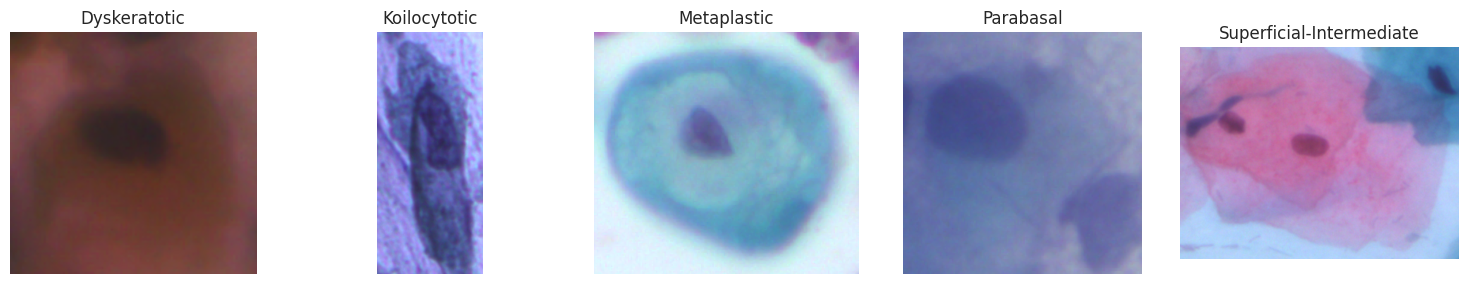

In [ ]:
# Visualize a sample of images from each of the 5 classes

# Retrieve the list of class names (subdirectory names)
class_names = [d for d in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, d))]

# Initialize lists to store images and their corresponding class labels
images = []
labels = []

# Iterate over each class to select one random image
for class_name in class_names:
    class_path = os.path.join(input_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith('.bmp')]
    if image_files:
        selected_image = random.choice(image_files)
        image_path = os.path.join(class_path, selected_image)
        try:
            img = Image.open(image_path)
            images.append(img)
            labels.append(class_name)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")

# Determine the number of images to display
num_images = len(images)

# Set up the plot
plt.figure(figsize=(15, 3))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

# 4 Data Splitting

In [ ]:
# Split ration
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Define the expected subdirectories
expected_subdirs = ['train', 'val', 'test']

# Check if the output directory and expected subdirectories exist
if os.path.exists(output_dir) and all(os.path.exists(os.path.join(output_dir, subdir)) for subdir in expected_subdirs):
    print(f"Dataset already split in '{output_dir}'. Skipping splitting.")
else:
    print(f"Splitting dataset from '{input_dir}' into '{output_dir}'...")
    splitfolders.ratio(input_dir, output=output_dir, seed=42, ratio=(.8, .1, .1))
    print("Dataset splitting completed.")

Dataset already split in '/content/drive/MyDrive/2025/MCSC_Research/cancer_dataset/output'. Skipping splitting.


# 5 Image Preprocessing

In [ ]:
""""
Load the training, validation, and testing datasets from Google Drive into TensorFlow
Normalize and Aurgement the images
"""

# Define image size and batch size
IMG_SIZE = (300, 300)  # EfficientNetB3 expects 300x300 image
batch_size = 32

AUTOTUNE = tf.data.AUTOTUNE

# Define the data augmentation and normalization pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.Rescaling(1./255)
])

# CNNs Image Preprocessing Pipeline

# Load the training dataset and apply data augmentation and normalization
train_path = os.path.join(output_dir, "train")
cnn_train_ds = image_dataset_from_directory(
    train_path,
    image_size=IMG_SIZE,
    batch_size=batch_size
)
cnn_train_ds = cnn_train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Load the validation dataset and apply only normalization
val_path = os.path.join(output_dir, "val")
cnn_val_ds = image_dataset_from_directory(
    val_path,
    image_size=IMG_SIZE,
    batch_size=batch_size
)
normalization_layer = layers.Rescaling(1./255)
cnn_val_ds = cnn_val_ds.map(lambda x, y: (normalization_layer(x), y))

# Performance Optimization by using .cache() and .prefetch()
cnn_train_ds = cnn_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
cnn_val_ds = cnn_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Load the testing dataset and apply only normalization
test_path = os.path.join(output_dir, "test")
cnn_test_ds = image_dataset_from_directory(
    test_path,
    image_size=IMG_SIZE,
    batch_size=batch_size
)
cnn_test_ds = cnn_test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 3237 files belonging to 5 classes.
Found 403 files belonging to 5 classes.
Found 409 files belonging to 5 classes.


# 6 Model Selection

In [ ]:
# 6 Load EfficientNetB3 without the top layer
base_model = EfficientNetB3(input_shape=IMG_SIZE + (3,),
                            include_top=False,
                            weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Determine the number of classes
num_classes = len(os.listdir(input_dir))

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# 7 Model Compilation

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 8 Model Training

In [ ]:
# Incorporate early stopping to monitor validation performance
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model on the SIPaKMeD dataset:​
history = model.fit(cnn_train_ds,
                    validation_data=cnn_val_ds,
                    epochs=100,
                    callbacks=[early_stop])

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.1999 - loss: 1.6381 - val_accuracy: 0.2060 - val_loss: 1.6180
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.2066 - loss: 1.6408 - val_accuracy: 0.2010 - val_loss: 1.6188
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.1943 - loss: 1.6433 - val_accuracy: 0.2060 - val_loss: 1.6105
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.1868 - loss: 1.6410 - val_accuracy: 0.2010 - val_loss: 1.6204
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.1941 - loss: 1.6438 - val_accuracy: 0.2035 - val_loss: 1.6307
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 0.1997 - loss: 1.6399 - val_accuracy: 0.1960 - val_loss: 1.6283
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 0.2003 - loss: 1.6407 - val_accuracy: 0.1935 - val_loss: 1.6326
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.1934 -

# 9 Model Evaluation

In [ ]:
# Evaluate the model's performance on the test dataset
test_loss, test_accuracy = model.evaluate(cnn_test_ds)
print(f'Test accuracy: {test_accuracy:.2f}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 87s 7s/step - accuracy: 0.1714 - loss: 1.6250
Test accuracy: 0.20


# 10 Model Deployment